In [1]:
import pandas as pd

vehicle_df = pd.read_csv('filtered_vehicle.csv')
accident_df = pd.read_csv('accident.csv')
person_df = pd.read_csv('person.csv')

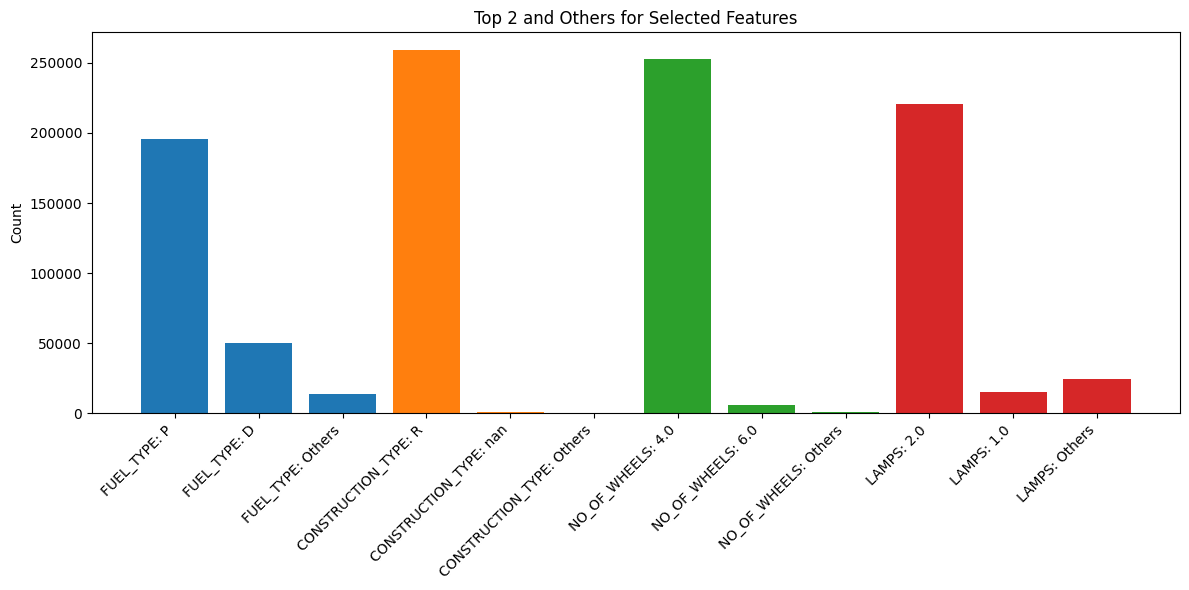

In [2]:
#  This code is used for descriptive statistics. 
# If the proportion of a certain value in some attributes is too large, it is not very meaningful to continue discussing it.

import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

columns_to_plot = ['FUEL_TYPE', 'CONSTRUCTION_TYPE', 'NO_OF_WHEELS', 'LAMPS']

summary_df = pd.DataFrame()

for col in columns_to_plot:
    ncounts = vehicle_df[col].value_counts(dropna=False)   # Count the number of occurrences of each category (including missing values).
    
    top2 = ncounts.nlargest(2)
    others = ncounts.iloc[2:].sum()

    temp_df = pd.DataFrame({
        'Feature': [col]*3,
        'Category': list(top2.index) + ['Others'],
        'Count': list(top2.values) + [others]
    })

    summary_df = pd.concat([summary_df, temp_df], ignore_index=True)


plt.figure(figsize=(12, 6))
for i, feature in enumerate(columns_to_plot):
    subset = summary_df[summary_df['Feature'] == feature]
    plt.bar(
        [f"{feature}: {a}" for a in subset['Category']],
        subset['Count'],
        label=feature
    )

plt.ylabel("Count")
plt.title("Top 2 and Others for Selected Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [3]:
# Processing Year of Manufacture: Average
print(vehicle_df.shape)  
print(vehicle_df['VEHICLE_YEAR_MANUF'].isnull().sum())  # Check if the manufacturing year column has missing values  7

# Delete rows where the VEHICLE_YEAR_MANUF column is empty
vehicle_df = vehicle_df.dropna(subset=['VEHICLE_YEAR_MANUF'])
#print(vehicle_df['VEHICLE_YEAR_MANUF'].isnull().sum())  


# Calculate the average manufacturing year by group
car_year = vehicle_df.groupby('ACCIDENT_NO')['VEHICLE_YEAR_MANUF'].mean().reset_index()  # Convert the index ACCIDENT_NO to a normal column

car_year['VEHICLE_YEAR_MANUF_h'] = car_year['VEHICLE_YEAR_MANUF'].round().astype(int)

vehicle_df = vehicle_df.merge(
    car_year[['ACCIDENT_NO', 'VEHICLE_YEAR_MANUF_h']], on='ACCIDENT_NO', how='left')
print(vehicle_df.shape) 

(259455, 37)
7
(259448, 38)


In [4]:
# Mark the original ROAD_SURFACE_TYPE of 9 as missing
vehicle_df['ROAD_SURFACE_TYPE_h'] = vehicle_df['ROAD_SURFACE_TYPE'].replace(9, pd.NA)
print(vehicle_df['ROAD_SURFACE_TYPE_h'].isnull().sum())
mode_all = vehicle_df['ROAD_SURFACE_TYPE_h'].mode()[0] # Calculate the mode of all ROAD_SURFACE_TYPE_h


def fill_with_mode(series):
    mode = series.mode()
    return series.fillna(mode[0]) if not mode.empty else series
# If mode is empty (i.e. no mode is found), no filling is done and the original series is returned directly 
# (that is, if all values ​​under a certain ACCIDENT_NO are 9 and there is no mode, NaN is not filled).

# Fill missing values ​​in ROAD_SURFACE_TYPE_h by grouping by ACCIDENT_NO
vehicle_df['ROAD_SURFACE_TYPE_h'] = (
    vehicle_df.groupby('ACCIDENT_NO')['ROAD_SURFACE_TYPE_h'].transform(fill_with_mode))
# transform() returns a result with the same shape as the original data.
print(vehicle_df['ROAD_SURFACE_TYPE_h'].isnull().sum())

vehicle_df['ROAD_SURFACE_TYPE_h'] = vehicle_df['ROAD_SURFACE_TYPE_h'].fillna(mode_all).astype(int)
print(vehicle_df['ROAD_SURFACE_TYPE_h'].isnull().sum())
print(vehicle_df.shape)

1802


C:\Users\Administrator\AppData\Local\Temp\ipykernel_21744\69440656.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return series.fillna(mode[0]) if not mode.empty else series


1733
0
(259448, 39)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_21744\69440656.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vehicle_df['ROAD_SURFACE_TYPE_h'] = vehicle_df['ROAD_SURFACE_TYPE_h'].fillna(mode_all).astype(int)


In [5]:
# One-hot encode ROAD_SURFACE_TYPE_h
ROAD_SURFACE_TYPE_dummies = pd.get_dummies(vehicle_df['ROAD_SURFACE_TYPE_h'], prefix='ROAD_SURFACE_TYPE_h', dtype=int)

vehicle_df = pd.concat([vehicle_df, ROAD_SURFACE_TYPE_dummies], axis=1)

# View the number of processed columns and newly added columns
print(vehicle_df.shape)
print(ROAD_SURFACE_TYPE_dummies.columns.tolist())

(259448, 42)
['ROAD_SURFACE_TYPE_h_1', 'ROAD_SURFACE_TYPE_h_2', 'ROAD_SURFACE_TYPE_h_3']


In [6]:
# One-hot encode FUEL_TYPE
FUEL_TYPE_dummies = pd.get_dummies(vehicle_df['FUEL_TYPE'], prefix='FUEL_TYPE', drop_first=True, dtype=int)
vehicle_df = pd.concat([vehicle_df, FUEL_TYPE_dummies], axis=1)

print(vehicle_df.shape)
print(FUEL_TYPE_dummies.columns.tolist())

(259448, 49)
['FUEL_TYPE_E', 'FUEL_TYPE_G', 'FUEL_TYPE_M', 'FUEL_TYPE_O', 'FUEL_TYPE_P', 'FUEL_TYPE_S', 'FUEL_TYPE_Z']


In [7]:
# SEATING_CAPACITY The rated capacity and TOTAL_NO_OCCUPANTS The actual number of passengers in the vehicle when the accident occurred. 
# Determine whether it is overloaded
print("SEATING_CAPACITY missing value num: ", vehicle_df['SEATING_CAPACITY'].isnull().sum())
print("TOTAL_NO_OCCUPANTS missing value num: ", vehicle_df['TOTAL_NO_OCCUPANTS'].isnull().sum())


# Generate a new column to indicate whether it is overloaded, 1 is overloaded, 0 is not overloaded
vehicle_df['IS_OVERLOADED_h'] = (vehicle_df['TOTAL_NO_OCCUPANTS'] > vehicle_df['SEATING_CAPACITY']).astype(int)
print(vehicle_df.shape)

SEATING_CAPACITY missing value num:  0
TOTAL_NO_OCCUPANTS missing value num:  0
(259448, 50)


In [8]:
#  calculate the weight
print("TARE_WEIGHT missing value num: ", vehicle_df['TARE_WEIGHT'].isnull().sum())
print("CARRY_CAPACITY missing value num: ", vehicle_df['CARRY_CAPACITY'].isnull().sum())

def calculate_weight(row):
    # If VEHICLE_WEIGHT has a value, use VEHICLE_WEIGHT directly
    if pd.notna(row['VEHICLE_WEIGHT']):
        return row['VEHICLE_WEIGHT']
    
    # If VEHICLE_WEIGHT is null, and both TARE_WEIGHT and CARRY_CAPACITY have values, TARE_WEIGHT + CARRY_CAPACITY is used.
    elif pd.notna(row['TARE_WEIGHT']) and pd.notna(row['CARRY_CAPACITY']):
        return row['TARE_WEIGHT'] + row['CARRY_CAPACITY']
    
    # If TARE_WEIGHT or CARRY_CAPACITY is empty, use TARE_WEIGHT + TOTAL_NO_OCCUPANTS * 75
    elif pd.notna(row['TARE_WEIGHT']) and pd.notna(row['TOTAL_NO_OCCUPANTS']):
        return row['TARE_WEIGHT'] + row['TOTAL_NO_OCCUPANTS'] * 75    
    # If there is no value, return NaN or other processing methods
    else:
        return pd.NA


vehicle_df['VEHICLE_WEIGHT_h'] = vehicle_df.apply(calculate_weight, axis=1)
print("TARE_WEIGHT_h missing value num: ", vehicle_df['VEHICLE_WEIGHT_h'].isnull().sum())
print(vehicle_df.shape)


TARE_WEIGHT missing value num:  0
CARRY_CAPACITY missing value num:  219765
TARE_WEIGHT_h missing value num:  0
(259448, 51)


In [9]:
# Compare VEHICLE_MOVEMENT and DRIVER_INTENT, add a new column 
# find the missing values ​​first, and the result is whether the operation is in accordance with the driver's idea, 1 means the same
print("DRIVER_INTENT missing value num: ",vehicle_df['DRIVER_INTENT'].isnull().sum())
print("VEHICLE_MOVEMENT missing value num: ",vehicle_df['VEHICLE_MOVEMENT'].isnull().sum())  

def match_intent(row):
    a = int(row['VEHICLE_MOVEMENT'] == row['DRIVER_INTENT'])
    return a

vehicle_df['INTENT_MATCH_h'] = vehicle_df.apply(match_intent, axis=1)
print(vehicle_df.shape)

DRIVER_INTENT missing value num:  0
VEHICLE_MOVEMENT missing value num:  1
(259448, 52)


In [10]:
# The values ​​of INITIAL_IMPACT are mapped to five more simplified categories: front_corner, front_side, rear_side, rear_corner, other
# One-hot encoding
impact_mapping = {
    '1': '1', '5': '1',  # front_corner = 1
    '2': '2', '6': '2', 'F': '2',  # front_side = 2
    '3': '3', '7': '3', 'R': '3',   # rear_side = 3
    '4': '4', '8': '4',   # rear_corner = 4
    '0': '5', '9': '5', 'N': '5',   # other = 5
    'S': '5', 'T': '5', 'U': '5', '_': '5'
}

vehicle_df['INITIAL_IMPACT_h'] = vehicle_df['INITIAL_IMPACT'].astype(str).map(impact_mapping)

impact_dummies = pd.get_dummies(vehicle_df['INITIAL_IMPACT_h'], prefix='INITIAL_IMPACT_h', drop_first=True, dtype=int)

vehicle_df = pd.concat([vehicle_df, impact_dummies], axis=1)
print(vehicle_df.shape)
print(impact_dummies.columns.tolist())

(259448, 57)
['INITIAL_IMPACT_h_2', 'INITIAL_IMPACT_h_3', 'INITIAL_IMPACT_h_4', 'INITIAL_IMPACT_h_5']


In [11]:
vehicle_df.to_csv('output_vehicle.csv', index=False)

In [12]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
person_df = pd.read_csv('person.csv')

# Handling null values ​​for 'HELMET_BELT_WORN'
make = person_df['HELMET_BELT_WORN']
mode_make = make.mode()[0]
make = make.fillna(mode_make)
person_df['HELMET_BELT_WORN'] = make
person_df['HELMET_BELT_WORN'].isnull().sum()

# Fill the empty value of sex with unknown
person_df['SEX'] = person_df['SEX'].fillna('U')


# One-hot encode 'SEX' and 'ROAD_USER_TYPE_DESC'
encoder = OneHotEncoder(sparse_output=False, drop='first')  # n-1 column in dummy variables
encoded_data = encoder.fit_transform(person_df[['SEX', 'ROAD_USER_TYPE_DESC']])
new_columns = encoder.get_feature_names_out(['SEX', 'ROAD_USER_TYPE_DESC'])
encoded_df = pd.DataFrame(encoded_data, columns=new_columns)
person_df = pd.concat([person_df.drop(['SEX', 'ROAD_USER_TYPE_DESC'], axis=1), encoded_df], axis=1)


# Convert the age groups in the AGE_GROUP column to a simplified form and convert them to numeric values
def convert_age_groups(df):
    df['AGE_GROUP'] = (
        df['AGE_GROUP'].astype(str) 
        .str.replace("'", "", regex=False)   
        .str.strip()                          
        .str.replace("–", "-", regex=False)  
    )
    
    # Simplified age group mapping
    age_mapping = {
        '0-4': 'Under 16',
        '5-12': 'Under 16',
        '13-15': 'Under 16',
        '16-17': '17-25',
        '18-21': '17-25',
        '22-25': '17-25',
        '26-29': '26-39',
        '30-39': '26-39',
        '40-49': '40-64',
        '50-59': '40-64',
        '60-64': '40-64',
        '65-69': '65+',
        '70+': '65+',
        'Unknown': 'Unknown'
    }

    df['AGE_GROUP'] = df['AGE_GROUP'].map(age_mapping)
    
    return df

person_df = convert_age_groups(person_df)

# Convert AGE_GROUP to numeric encoding
def convert_age_groups_to_numeric(df):
    age_mapping_numeric = {
        'Under 16': 0,
        '17-25': 1,
        '26-39': 2,
        '40-64': 3,
        '65+': 4,
        'Unknown': 5
    }

    df['AGE_GROUP'] = df['AGE_GROUP'].map(age_mapping_numeric)
    
    return df

person_df = convert_age_groups_to_numeric(person_df)


In [13]:
#  Handling seat belt risk scenarios
def worn_risk(i):
    high_risk_codes = [2, 4, 5, 7]  # High risk codes: not fastened, not restrained, not installed, not wearing a helmet
    if i in high_risk_codes:
        return 1
    else:
        return 0

person_df['HELMET_BELT_WORN_risk'] = person_df['HELMET_BELT_WORN'].apply(worn_risk)


In [14]:
person_df.to_csv('output_person.csv', index=False)

In [15]:
import pandas as pd
# Start processing the data in accident.csv
accident_df = pd.read_csv('accident.csv')

# Check if ACCIDENT_NO has a null value
missing_accident_no = accident_df['ACCIDENT_NO'].isnull().sum()
print(f"Number of missing ACCIDENT_NOs: {missing_accident_no}")
print(accident_df.shape)

accident_df = accident_df[accident_df['ACCIDENT_TIME'].notna()]
accident_df['HOUR'] = accident_df['ACCIDENT_TIME'].str.extract(r'^(\d{1,2})')[0].astype(int)

def map_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Late Night'

a = accident_df['HOUR'].apply(map_time_of_day)

# Mapping time periods to codes
time_mapping = {
    'Morning': 1,
    'Afternoon': 2,
    'Evening': 3,
    'Late Night': 4
}

accident_df['TIME_OF_DAY_CODE'] = a.map(time_mapping)

print(accident_df.shape)


Number of missing ACCIDENT_NOs: 0
(178695, 23)
(178695, 25)


In [16]:
# One-hot encoding ACCIDENT_TYPE
accident_type_dummies = pd.get_dummies(accident_df['ACCIDENT_TYPE'], prefix='ACCIDENT_TYPE', dtype=int)

accident_df = pd.concat([accident_df, accident_type_dummies], axis=1)

print(accident_df.shape)
print(accident_type_dummies.columns.tolist())
print(accident_df.shape)

(178695, 34)
['ACCIDENT_TYPE_1', 'ACCIDENT_TYPE_2', 'ACCIDENT_TYPE_3', 'ACCIDENT_TYPE_4', 'ACCIDENT_TYPE_5', 'ACCIDENT_TYPE_6', 'ACCIDENT_TYPE_7', 'ACCIDENT_TYPE_8', 'ACCIDENT_TYPE_9']
(178695, 34)


In [17]:
#  Processing DCA code
missing_accident_no = accident_df['DCA_CODE'].isnull().sum()
print(f"Number of missing DCA_CODEs: {missing_accident_no}")

print("Minimum value: ", min(accident_df['DCA_CODE']))
print("Maximum value:", max(accident_df['DCA_CODE']))

accident_df['DCA_GROUP'] = accident_df['DCA_CODE'] // 10
dca_group_map = {
    10: 'Pedestrian',
    11: 'Cross Traffic',
    12: 'Head-on',
    13: 'Same Direction',
    14: 'Parking',
    15: 'Overtaking',
    16: 'Side Objects',
    17: 'Off Road Straight',
    18: 'Off Road Curve',
    19: 'Other'
}
accident_df['DCA_GROUP'] = accident_df['DCA_GROUP'].map(dca_group_map)

dca_dummies = pd.get_dummies(accident_df['DCA_GROUP'], prefix='DCA', dtype=int)
accident_df = pd.concat([accident_df, dca_dummies], axis=1)
print(dca_dummies.columns.tolist())
print(accident_df.shape)

Number of missing DCA_CODEs: 0
Minimum value:  100
Maximum value: 199
['DCA_Cross Traffic', 'DCA_Head-on', 'DCA_Off Road Curve', 'DCA_Off Road Straight', 'DCA_Other', 'DCA_Overtaking', 'DCA_Parking', 'DCA_Pedestrian', 'DCA_Same Direction', 'DCA_Side Objects']
(178695, 45)


In [18]:
# handle light conditions

light_condition_dummies = pd.get_dummies(accident_df['LIGHT_CONDITION'], prefix='LIGHT_CONDITION', dtype=int)
accident_df = pd.concat([accident_df, light_condition_dummies], axis=1)
print(light_condition_dummies.columns.tolist())
print(accident_df.shape)

['LIGHT_CONDITION_1', 'LIGHT_CONDITION_2', 'LIGHT_CONDITION_3', 'LIGHT_CONDITION_4', 'LIGHT_CONDITION_5', 'LIGHT_CONDITION_6', 'LIGHT_CONDITION_9']
(178695, 52)


In [19]:
# handle road geometry

road_geometry_dummies = pd.get_dummies(accident_df['ROAD_GEOMETRY'], prefix='ROAD_GEOMETRY', dtype=int)
accident_df = pd.concat([accident_df, road_geometry_dummies], axis=1)
print(road_geometry_dummies.columns.tolist())
print(accident_df.shape)

['ROAD_GEOMETRY_1', 'ROAD_GEOMETRY_2', 'ROAD_GEOMETRY_3', 'ROAD_GEOMETRY_4', 'ROAD_GEOMETRY_5', 'ROAD_GEOMETRY_6', 'ROAD_GEOMETRY_7', 'ROAD_GEOMETRY_8', 'ROAD_GEOMETRY_9']
(178695, 61)


In [20]:
# handle speed zone

# Convert SPEED_ZONE to integer type
SPEED_ZONE_INT = pd.to_numeric(accident_df['SPEED_ZONE'], errors='coerce')

# Classification by conditions
def categorize_speed_zone(speed):
    if pd.isna(speed):
        return 'Unknown Zone'  
    elif speed <= 50:
        return 'Low Speed Zone'
    elif speed <= 80:
        return 'Medium Speed Zone'
    elif speed <= 110:
        return 'High Speed Zone'
    else:
        return 'Unknown Zone'  # Values ​​greater than 110 or other unpredictable values ​​are classified as unknown

accident_df['SPEED_ZONE_CATEGORY'] = SPEED_ZONE_INT.apply(categorize_speed_zone)
print(accident_df[['SPEED_ZONE', 'SPEED_ZONE_CATEGORY']].head())

speed_zone_dummies = pd.get_dummies(accident_df['SPEED_ZONE_CATEGORY'], prefix='SPEED_ZONE', dtype=int)
accident_df = pd.concat([accident_df, speed_zone_dummies], axis=1)

print(speed_zone_dummies.columns.tolist())
print(accident_df.shape)

   SPEED_ZONE SPEED_ZONE_CATEGORY
0          60   Medium Speed Zone
1         100     High Speed Zone
2          60   Medium Speed Zone
3         100     High Speed Zone
4         100     High Speed Zone
['SPEED_ZONE_High Speed Zone', 'SPEED_ZONE_Low Speed Zone', 'SPEED_ZONE_Medium Speed Zone', 'SPEED_ZONE_Unknown Zone']
(178695, 66)


In [21]:
accident_df.to_csv('output_accident.csv', index=False)